In [1]:
from imports import *
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_moon
%matplotlib notebook

## define functions to compute window functions given targets and observatories

In [2]:
def compute_WF(target_dicts, tel_dicts, outfname='output_data/summary.txt'):
    '''Given a set of targets to be observed with a set of telescopes, construct a sample window function 
    taking into account weather, target prioritization, exposure time, etc.'''
    # ensure that all necessary information is included in the input
    _dicts_complete(target_dicts, tel_dicts)
    
    # save the input for reference
    _save_input(target_dicts, tel_dicts, outfname)
    
    # compute for each target and with each telescope WF
    df_times = pd.DataFrame()
    target_times, target_names, telescope_names = np.zeros(0), np.zeros(0), np.zeros(0)
    RVnoise, eRV, seeing, airmass = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)
    sunalt, moonalt, illumination = np.zeros(0), np.zeros(0), np.zeros(0)
    for i,d1 in enumerate(target_dicts):
        for j,d2 in enumerate(tel_dicts):
            # sample a window function given the input parameters
            print('\nObserving %s with %s\n'%(d1['target_name'], d2['telescope_name']))
            p = _define_WF_onetarget_onetelescope(d1, d2, Ntargets_total=len(target_dicts))
            times,rvnoise,erv,seeingtmp,airmasstmp,sunalttmp,moonalttmp,illuminationtmp = p
            target_times    = np.append(target_times, times)
            target_names    = np.append(target_names, np.repeat(d1['target_name'], times.size))
            telescope_names = np.append(telescope_names, np.repeat(d2['telescope_name'], times.size))            
            RVnoise         = np.append(RVnoise, rvnoise)
            eRV             = np.append(eRV, erv)
            seeing          = np.append(seeing, seeingtmp)
            airmass         = np.append(airmass, airmasstmp)
            sunalt          = np.append(sunalt, sunalttmp)
            moonalt         = np.append(moonalt, moonalttmp)
            illumination    = np.append(illumination, illuminationtmp)
            
    # combine timeseries from different telescopes
    s = np.argsort(target_times)
    df_times['times']        = target_times[s]
    df_times['target_names'] = target_names[s]
    df_times['telescopes']   = telescope_names[s]
    df_times['RV_noise']     = RVnoise[s]
    df_times['sigmaRV']      = eRV[s]
    df_times['seeing']       = seeing[s]
    df_times['airmass']      = airmass[s]
    df_times['sunalt']       = sunalt[s]
    df_times['moonalt']      = moonalt[s]
    df_times['illumination'] = illumination[s]

    # combine WFs somehow
    return df_times

In [3]:
def _dicts_complete(target_dicts, tel_dicts):
    '''Ensure that all necessary information is present to construct an accurate window function.'''
    assert type(target_dicts) == list
    for _,d in enumerate(target_dicts):
        assert np.all(np.in1d(['target_name','ra_deg','dec_deg'], list(d.keys())))                              
    assert type(tel_dicts) == list
    for _,d in enumerate(tel_dicts):
        assert np.all(np.in1d(['telescope_name','lat_deg','lon_deg','elevation_m','toverhead_min','median_seeing_arcsec'],
                              list(d.keys())))
    for i,d1 in enumerate(target_dicts):
        for j,d2 in enumerate(tel_dicts):
            assert '%s_%s'%(d1['target_name'], d2['telescope_name']) in sigmaRV_dict.keys()
        
        
def _save_input(target_dicts, tel_dicts, outfname):
    '''Save the input parameters of the targets and telescopes for reference.'''
    # save constants
    g = 'min_twilight_deg:\t%.1f\n'%min_twilight_deg
    g += 'max_airmass:\t%.1f\n'%max_airmass
    g += 'N_D_beforeandaftertransit:\t%.1f\n'%N_D_beforeandaftertransit
    g += 'max_night_len_hrs:\t%.1f\n\n'%max_night_len_hrs

    # save targets to the file
    for i,d1 in enumerate(target_dicts):
        for k in d1.keys():
            g += '%s:\t%s\n'%(k, str(d1[k]))
            
    # save telescopes to the file
    for i,d1 in enumerate(tel_dicts):
        g += '\n'
        for k in d1.keys():
            g += '%s:\t%s\n'%(k, str(d1[k]))
        # include RV uncertainty for each target
        for j,d2 in enumerate(target_dicts):
            g+= 'sigmaRV_%s_mps:\t%.3f\n'%(d2['target_name'],
                                           sigmaRV_dict['%s_%s'%(d2['target_name'], d1['telescope_name'])])
    
    # save the file
    h = open(outfname, 'w')
    h.write(g)
    h.close()

In [4]:
def _define_WF_onetarget_onetelescope(target_dict, tel_dict, transit_csv='', Ntargets_total=1):
    '''Construct a window function for a target from a given telescope site.'''  
    # initialize array of potential observations epochs
    dtarr = np.arange(0, tel_dict['survey_len_yrs']*365.25*24*60, 
                      target_dict['texp_min']+tel_dict['toverhead_min'])*u.min
    times = Time(tel_dict['start_date']) + dtarr
    times += np.random.uniform(-1, 1, times.size)/24  # add noise
    times = Time(np.sort(times))
    
    # ensure that the Sun is not up
    print('Restricting to daytime with twilight = %.1f deg...'%min_twilight_deg)
    if times.size>0: tokeep,sunalt,night_edge_inds = _exclude_daytime(times, tel_dict)
    times, sunalt = _index_input_arrays(tokeep, times, sunalt)
    
    # restrict to bright time if necessary
    print('Restricting to bright time with the Moon > %.1f deg...'%tel_dict['min_Moon_alt'])
    if times.size>0: tokeep, moonalt, illumination = _exclude_darktime(Time(times), tel_dict)
    times, sunalt, moonalt, illumination = _index_input_arrays(tokeep, times, sunalt, moonalt, illumination)
        
    # include random weather losses
    print('Applying random weather losses to %.1f%% of nights...'%(tel_dict['fractional_weather_loss']*1e2))
    if times.size>0: tokeep = _exclude_weather_losses(Time(times), night_edge_inds, tel_dict)
    times, sunalt, moonalt, illumination = _index_input_arrays(tokeep, times, sunalt, moonalt, illumination)
    
    # only observe above a certain airmass
    print('Restricting to above airmass of %.1f...'%max_airmass)
    if times.size>0: tokeep, airmass = _exclude_low_airmass(Time(times), target_dict, tel_dict)
    times,sunalt,moonalt,illumination,airmass = _index_input_arrays(tokeep, times, sunalt, moonalt, 
                                                                    illumination, airmass)    

    # remove points spaced closely in time
    print('Restricting to %i points per night and separated by > %.2f minutes...'%(tel_dict['Npernight'], 
                                                                                   tel_dict['dtmin_min']))
    if times.size>0: tokeep = _limit_nightly_pnts(Time(times), tel_dict)
    times,sunalt,moonalt,illumination,airmass = _index_input_arrays(tokeep, times, sunalt, moonalt, 
                                                                    illumination, airmass)    
    
    # exclude epochs that have a priority transit from another target
    if transit_csv != '':
        print('Excluding in-transit epochs of priority targets...')
        if times.size>0: tokeep = _exclude_transits(Time(times), transit_csv)
        times,sunalt,moonalt,illumination,airmass = _index_input_arrays(tokeep, times, sunalt, moonalt, 
                                                                        illumination, airmass)    
          
    # lastly, of all the available time, restrict to the fraction that is available for the desired program
    if times.size>0: tokeep = _exclude_fraction_of_nights(Time(times), tel_dict, Ntargets_total=Ntargets_total)
    times,sunalt,moonalt,illumination,airmass = _index_input_arrays(tokeep, times, sunalt, moonalt,
                                                                    illumination, airmass)    

    # compute the seeing, airmass, and resulting RV uncertainties
    print('Scaling RVs by seeing and airmass...')
    if times.size>0: 
        RVnoise, eRV, seeing, airmass = _sample_eRV(Time(times), target_dict, tel_dict)
    else:
        RVnoise, eRV, seeing, airmass = np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0)
        
    # return timeseries of interest including the window function 
    return Time(times), RVnoise, eRV, seeing, airmass, sunalt, moonalt, illumination
    


def _index_input_arrays(indices, *args):
    '''Given a set of indices to keep, restrict and return the input arrays based on the indicies.'''
    out = []
    for arr in args:
        try:
            assert arr.size == indices.size
        except AssertionError:
            print(arr)
            raise ValueError('hi.')
        out.append(arr[indices])
    return tuple(out)



def _exclude_daytime(times, tel_dict):
    '''Given potential epochs of observation from a particular site, flag ones that occur during daytime.'''
    assert times.size > 0
    # setup location
    loc = EarthLocation(lat=tel_dict['lat_deg']*u.deg, lon=tel_dict['lon_deg']*u.deg, 
                        height=tel_dict['elevation_m']*u.m)
    frame = AltAz(obstime=times, location=loc)
    
    # get Sun's altitude at all times
    sunaltazs = get_sun(times).transform_to(frame)
    
    # only consider when the Sun is below the twilight altitude
    g = sunaltazs.alt.deg < min_twilight_deg
    
    # get indices separating nights
    night_edge_inds = np.append(0, np.where(np.diff(np.where(sunaltazs.alt.deg > min_twilight_deg)[0]) > 1)[0])
    return g, sunaltazs.alt.deg, night_edge_inds



def _exclude_darktime(times, tel_dict):
    '''Given potential epochs of observation from a particular site, exclude epochs that occur during dark time
    such as on CFHT.'''
    assert times.size > 0
    # setup location
    loc = EarthLocation(lat=tel_dict['lat_deg']*u.deg, lon=tel_dict['lon_deg']*u.deg, 
                        height=tel_dict['elevation_m']*u.m)
    frame = AltAz(obstime=times, location=loc)
    
    # compute Moon location and illumination
    sun, moon = get_sun(times), get_moon(times)
    moonalt = np.array(get_moon(times).transform_to(frame).alt)     
    elongation = sun.separation(moon)
    i = np.arctan2(sun.distance*np.sin(elongation), moon.distance - sun.distance*np.cos(elongation))
    k = (1 + np.cos(i))/2.0
    illumination = k.value
    
    # restrict to where Moon is above some altitude and is sigfnicantly illuminated by the Sun
    g = (moonalt>tel_dict['min_Moon_alt']) & (illumination>tel_dict['min_lunar_illumination'])
    return g, moonalt, illumination



def _exclude_weather_losses(times, night_edge_inds, tel_dict):
    '''Given potential epochs of observation, randomly omit epochs that have bad weather.'''
    good_weather = np.zeros(times.size, dtype=bool)
    for i in range(night_edge_inds.size-1):
        # randomly select this night as good or bad
        ind, jind = night_edge_inds[i], night_edge_inds[i+1]
        good_weather[ind:jind] = np.random.rand() <= 1. - tel_dict['fractional_weather_loss']
    return good_weather



def _exclude_low_airmass(times, target_dict, tel_dict):
    '''Given potential epochs of observation of a given target, flag epochs where the target is below the threshold
    airmass allowed.'''
    # only consider when the target is above a desired airmass
    altaz, airmass = _get_airmass(times, target_dict, tel_dict)
    g = (np.array(altaz.alt) > 0) & (np.array(airmass) <= max_airmass)
    return g, np.array(airmass)


def _get_airmass(times, target_dict, tel_dict):
        # define target location
    c = SkyCoord(target_dict['ra_deg'], target_dict['dec_deg'], frame='icrs', unit='deg')
    
    # set telescope location
    loc = EarthLocation(lat=tel_dict['lat_deg']*u.deg, lon=tel_dict['lon_deg']*u.deg, 
                        height=tel_dict['elevation_m']*u.m)
    frame = AltAz(obstime=times, location=loc)

    # compute airmass
    altaz = c.transform_to(frame)
    airmass = altaz.secz
    return altaz, airmass



def _limit_nightly_pnts(times, tel_dict):
    '''Given potential epochs of observation, exclude pnts that are not sufficiently separated in time and do not 
    occur too often within the same night.'''
    # flag nearby points
    timestmp = np.copy(times)
    tooclose = np.append(False, np.diff(timestmp)*24*60 < tel_dict['dtmin_min'])
    while np.any(tooclose):
        timestmp = timestmp[np.invert(tooclose)]
        tooclose = np.append(False, np.diff(timestmp)*24*60 < tel_dict['dtmin_min'])
    tokeep = np.in1d(times, timestmp)
        
    # ensure that only the maximum number of points per night are obtained
    tokeep_nightly = np.ones(times[tokeep].size, dtype=bool)
    for i,t in enumerate(Time(times[tokeep]).jd):
        thisnight = abs(Time(times[tokeep]).jd - t) < max_night_len_hrs/24.
        if thisnight.sum() > tel_dict['Npernight']:
            rand_inds = np.append(np.ones(tel_dict['Npernight']), 
                                  np.zeros(thisnight.sum()-tel_dict['Npernight']))
            np.random.shuffle(rand_inds)
            tokeep_nightly[thisnight] = rand_inds.astype(bool)
        
    # save times
    times_out = np.unique(np.append(times[tokeep], times[tokeep][tokeep_nightly]))
    tokeep_out = np.in1d(times, times_out)
    return tokeep_out



def _exclude_transits(times, transit_csv):
    '''Given potential epochs of observations, flag ones that occur around the transit of a priority target 
    whose ephemeris is given in the transit_csv file.'''
    # flag epochs that occur in and around transits
    intransit = np.zeros(times.size, dtype=bool)
    _,Ptransits, T0transits, Dtransits = np.loadtxt(transit_csv, delimiter=',').T
    for i in range(Ptransits.size):
        phase = foldAt(times.jd, Ptransits[i], T0transits[i])
        phase[phase>.5] -= 1
        phi_bound = Dtransits[i]*(1. + N_D_beforeandaftertransit) / (Ptransits[i]*24) # max(phase) on either side of the transit mid point
        intransit[np.isclose(abs(phase), 0, atol=phi_bound)] = True
    
    # only consider out-of-transit epochs
    return np.invert(intransit)



def _exclude_fraction_of_nights(times, tel_dict, Ntargets_total=1):
    '''Given a set of potential epochs of observation, randomly select those according to the fraction of 
    available time that is dedicated to the relevant observing program.'''
    # remove a fraction of epochs depending on how many can reasonably be used on one target
    g = np.random.rand(times.size) <= tel_dict['fraction_available_for_program']/float(Ntargets_total)
    return g



def _sample_seeing(times, tel_dict):
    '''Sample the seeing from a Rayleigh distribution scaled to the median seeing for that site.
    See sample distribution here: https://www.naoj.org/Observing/Telescope/ImageQuality/Seeing/'''
    # sample nightly distribution of seeing conditions
    pdf = np.random.rayleigh(1, times.size)
    mode = pdf.mean() * np.sqrt(2/np.pi)
    pdf *= tel_dict['median_seeing_arcsec'] / mode
    return pdf



def _sample_eRV(times, target_dict, tel_dict):
    '''Given a median sigmaRV value for a given target on a given telescope (see dictionary sigmaRV_dict),
    scale the resulting RV uncertainties and noise according to seeing and airmass.'''
    # get seeing and airmass at all times
    seeing = _sample_seeing(times, tel_dict)
    _,airmass = _get_airmass(times, target_dict, tel_dict)
    
    # scale the median RV uncertainty based on seeing
    eRV = np.repeat(float(sigmaRV_dict['%s_%s'%(target_dict['target_name'], tel_dict['telescope_name'])]), times.size)
    seeingfit, eRVfit = np.loadtxt('/Users/ryancloutier/Research/RVSurvey/input_data/seeing_eRV.txt').T # from HARPS-N ETC
    seeing2eRV = np.poly1d(np.polyfit(np.log10(seeingfit), np.log10(eRVfit), 3))
    eRV *= 10**seeing2eRV(np.log10(seeing)) / 10**seeing2eRV(np.log10(tel_dict['median_seeing_arcsec']))

    # scale the median RV uncertainty based on airmass
    airmassfit, eRVfit = np.loadtxt('/Users/ryancloutier/Research/RVSurvey/input_data/airmass_eRV.txt').T # from HARPS-N ETC
    airmass2eRV = np.poly1d(np.polyfit(airmassfit, eRVfit, 2))
    eRV *= airmass2eRV(airmass) / airmass2eRV(np.median(airmass))

    # add white noise to the RV signal
    RVnoise = np.random.normal(0, eRV, (1,eRV.size)).reshape(eRV.size)
    return RVnoise, eRV, seeing, airmass

## define input (targets, observatories, etc)

In [5]:
# define telescopes
tel_SPIRou = {'telescope_name':'SPIRou', 'lat_deg':19.8, 'lon_deg':-155.5, 'elevation_m':4200,
              'min_Moon_alt':-40, 'Npernight':1, 'dtmin_min':120, 'start_date':'2019-11-25', 'survey_len_yrs':.5,
              'fractional_weather_loss':.2, 'fraction_available_for_program':.25, 'median_seeing_arcsec':.6,
              'toverhead_min':5, 'min_lunar_illumination':.5}

tel_HARPSN = {'telescope_name':'HARPSN', 'lat_deg':28.7, 'lon_deg':-17.9, 'elevation_m':2370,
              'min_Moon_alt':-np.inf, 'Npernight':2, 'dtmin_min':60, 'start_date':'2019-11-25', 'survey_len_yrs':.5,
              'fractional_weather_loss':.4, 'fraction_available_for_program':.5, 'median_seeing_arcsec':1.2,
              'toverhead_min':5, 'min_lunar_illumination':.1}

tel_HARPS = {'telescope_name':'HARPS', 'lat_deg':-29.26, 'lon_deg':-70.74, 'elevation_m':2400,
             'min_Moon_alt':-np.inf, 'Npernight':1, 'dtmin_min':120, 'start_date':'2019-11-25', 'survey_len_yrs':.5,
             'fractional_weather_loss':.2, 'fraction_available_for_program':.5, 'median_seeing_arcsec':.87,
             'toverhead_min':5, 'min_lunar_illumination':.1}

tel_NIRPS = tel_HARPS.copy()
tel_NIRPS['telescope_name'] = 'NIRPS'
tel_NIRPS['fraction_available_for=_program'] = .25

In [6]:
# define targets
toi732 = {'target_name':'toi732','ra_deg':154.6449, 'dec_deg':-11.7178, 'texp_min':30}

In [7]:
# define median RV uncertainty for each target with each spectrograph 
sigmaRV_dict = {'toi732_SPIRou':2.25, 'toi732_HARPSN':4, 'toi732_HARPS':3.0, 'toi732_NIRPS':2.25}

In [8]:
# define globals
min_twilight_deg, max_airmass, N_D_beforeandaftertransit = -18, 2, .5
max_night_len_hrs = 10

## construct window functions

In [9]:
%%time
tel_dicts = [tel_SPIRou, tel_HARPSN, tel_HARPS, tel_NIRPS]
outfname = 'output_data/summary_toi732_full.txt'
df_times = compute_WF([toi732], tel_dicts, outfname=outfname)


Observing toi732 with SPIRou

Restricting to daytime with twilight = -18.0 deg...


Restricting to bright time with the Moon > -40.0 deg...
Applying random weather losses to 20.0% of nights...
Restricting to above airmass of 2.0...
Restricting to 1 points per night and separated by > 120.00 minutes...
Scaling RVs by seeing and airmass...

Observing toi732 with HARPSN

Restricting to daytime with twilight = -18.0 deg...
Restricting to bright time with the Moon > -inf deg...
Applying random weather losses to 40.0% of nights...
Restricting to above airmass of 2.0...
Restricting to 2 points per night and separated by > 60.00 minutes...
Scaling RVs by seeing and airmass...

Observing toi732 with HARPS

Restricting to daytime with twilight = -18.0 deg...
Restricting to bright time with the Moon > -inf deg...
Applying random weather losses to 20.0% of nights...
Restricting to above airmass of 2.0...
Restricting to 1 points per night and separated by > 120.00 minutes...
Scaling RVs by seeing and airmass...

Observing toi732 with NIRPS

Restricting to daytime with twilight = -

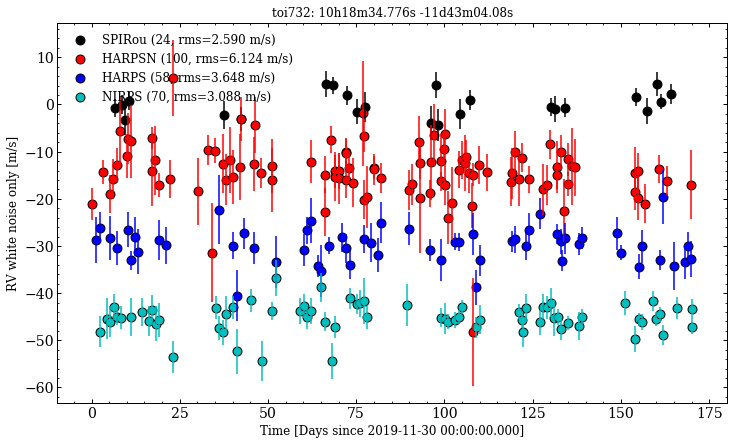

In [10]:
# plot timeseries
pltt, figout = 1, 'output_data/timeseries_full.png'
t0 = Time('2019-11-30')
target_dict = toi732
specs = [d['telescope_name'] for d in tel_dicts]
cols = ['k','r','b','c']
assert len(cols) >= len(specs)
dy = 25

plt.figure(figsize=(12,7))
for i,spec in enumerate(specs):
    g = (df_times['telescopes'] == spec) & (df_times['target_names'] == target_dict['target_name'])
    plt.errorbar(Time(df_times['times'][g]).jd-t0.jd, df_times['RV_noise'][g]-i*15, df_times['sigmaRV'][g],
                 fmt='o', color=cols[i], ms=0)
    plt.scatter(Time(df_times['times'][g]).jd-t0.jd, df_times['RV_noise'][g]-i*15, s=80, edgecolors='k', 
                facecolor=cols[i], label='%s (%i, rms=%.3f m/s)'%(spec, g.sum(), df_times['RV_noise'][g].std()))
    
plt.xlabel('Time [Days since %s]'%t0, fontsize=12), plt.ylabel('RV white noise only [m/s]', fontsize=12)
plt.title('%s: %s'%(target_dict['target_name'], 
                    SkyCoord(target_dict['ra_deg'],target_dict['dec_deg'],unit='deg').to_string(style='hmsdms')), 
          fontsize=12)
plt.legend(fontsize=12)
#plt.xlim((25,50))
if pltt: plt.savefig(figout)